In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from Manage_data.db_manager import get_data


In [54]:
def standardize_columns(df, columns):
    scaler = MinMaxScaler(feature_range=(0,1)) #=StandardScaler()
    df_copy = df.copy()
    df_copy[columns] = scaler.fit_transform(df[columns])
    stats = {
        col: {"mean": scaler.data_min_[i], "std": scaler.data_range_[i]}
        for i, col in enumerate(columns)
    }
    return df_copy, stats

def standardize_test_data(df, columns, stats):
    df_copy = df.copy()
    for col in columns:
        if col not in stats:
            raise ValueError(f"Statistics for column '{col}' not found in the provided stats.")
        if col not in df_copy.columns:
            raise ValueError(f"Column '{col}' not found in the test DataFrame.")
        
        min_val = stats[col]["mean"]
        range_val = stats[col]["std"]
        
        df_copy[col] = (df_copy[col] - min_val) / range_val

    return df_copy


In [55]:
def split_data(scaled_set, train_percentage=0.8, window_size=30):
    train_end_index = int(len(scaled_set) * train_percentage)

    X_train, y_train = [], []
    for i in range(window_size, train_end_index):
        X_train.append(scaled_set[i-window_size:i])
        y_train.append(scaled_set[i])
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    X_test, y_test = [], []
    for i in range(train_end_index, len(scaled_set)):
        X_test.append(scaled_set[i-window_size:i])
        y_test.append(scaled_set[i])
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    return X_train, y_train, X_test, y_test


In [56]:
df = get_data('META', granularity='daily')
df.drop(columns=['Title'], inplace=True)
df = df.sort_values(by="Date", ascending=True).reset_index(drop=True)

recent_dates = df[df['Date'] >= df['Date'].max() - pd.DateOffset(months=2)]
# Afficher les résultats
print(recent_dates)


df.head()

Adding Symbol: META
entry already exists or no title
           Date    Open    High     Low   Close  Adj_close    Volume
3173 2024-12-30  588.75  596.94  585.58  591.24     591.24   7025900
3174 2024-12-31  592.27  593.97  583.85  585.51     585.51   6019500
3175 2025-01-02  589.72  604.91  587.82  599.24     599.24  12682300
3176 2025-01-03  604.76  609.50  596.41  604.63     604.63  11436800
3177 2025-01-06  611.83  630.99  605.62  630.20     630.20  14560800
3178 2025-01-07  631.70  632.10  608.23  617.89     617.89  12071500
3179 2025-01-08  613.40  616.44  602.79  610.72     610.72  10085800
3180 2025-01-10  610.03  629.91  597.34  615.86     615.86  19256600
3181 2025-01-13  607.10  608.97  598.45  608.33     608.33  10785000
3182 2025-01-14  605.07  605.49  588.55  594.25     594.25  13598000
3183 2025-01-15  610.21  622.46  606.50  617.12     617.12  15524300
3184 2025-01-16  611.50  616.25  609.71  611.30     611.30   8355300
3185 2025-01-17  624.05  624.97  603.67  612.77   

,Date,Open,High,Low,Close,Adj_close,Volume
0,2012-05-18,42.05,45.00,38.00,38.23,38.08,573576400
1,2012-05-21,36.53,36.66,33.00,34.03,33.90,168192700
2,2012-05-22,32.61,33.59,30.94,31.00,30.88,101786600
3,2012-05-23,31.37,32.50,31.36,32.00,31.88,73600000
4,2012-05-24,32.95,33.21,31.77,33.03,32.90,50237200


In [57]:

columns_to_standardize = ['Open']  # Remplacez par les colonnes appropriées
df_standardized, stats = standardize_columns(df, columns_to_standardize)

# Préparation des données d'entraînement
train_set = df_standardized['Open'].values.reshape(-1, 1)  # Sélectionnez la colonne 'Open'

# Utilisation de la fonction split_data
X_train, y_train, X_test, y_test = split_data(train_set, train_percentage=0.8, window_size=30)

# Reshape pour correspondre à l'entrée du modèle PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Affichage des dimensions des ensembles
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


torch.Size([2541, 30, 1])
torch.Size([2541, 1])
torch.Size([643, 30, 1])
torch.Size([643, 1])


In [58]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=4, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h_0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c_0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return out

# Initialisation du modèle
input_size = 1  
hidden_size = 50
output_size = 1

model = LSTMModel(input_size, hidden_size, output_size)


In [59]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
#criterion = nn.L1Loss()

num_epochs = 20
batch_size = 32

# Entraînement du modèle
for epoch in range(num_epochs):
    model.train()
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():8f}')


Epoch [1/20], Loss: 0.000884
Epoch [2/20], Loss: 0.006655
Epoch [3/20], Loss: 0.009675
Epoch [4/20], Loss: 0.019921
Epoch [5/20], Loss: 0.026981
Epoch [6/20], Loss: 0.002322
Epoch [7/20], Loss: 0.001154
Epoch [8/20], Loss: 0.000849
Epoch [9/20], Loss: 0.000636
Epoch [10/20], Loss: 0.000500
Epoch [11/20], Loss: 0.000413
Epoch [12/20], Loss: 0.000362
Epoch [13/20], Loss: 0.000312
Epoch [14/20], Loss: 0.000297
Epoch [15/20], Loss: 0.000297
Epoch [16/20], Loss: 0.000280
Epoch [17/20], Loss: 0.000320
Epoch [18/20], Loss: 0.030852
Epoch [19/20], Loss: 0.046359
Epoch [20/20], Loss: 0.046720


Train MAE: 0.2108, Train MSE: 0.0555


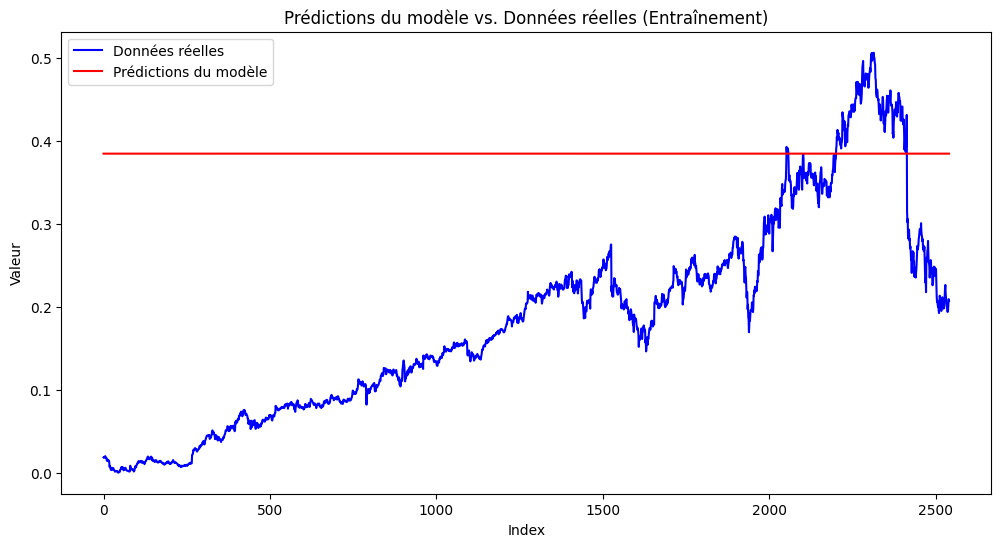

Test MAE: 0.1555, Test MSE: 0.0345


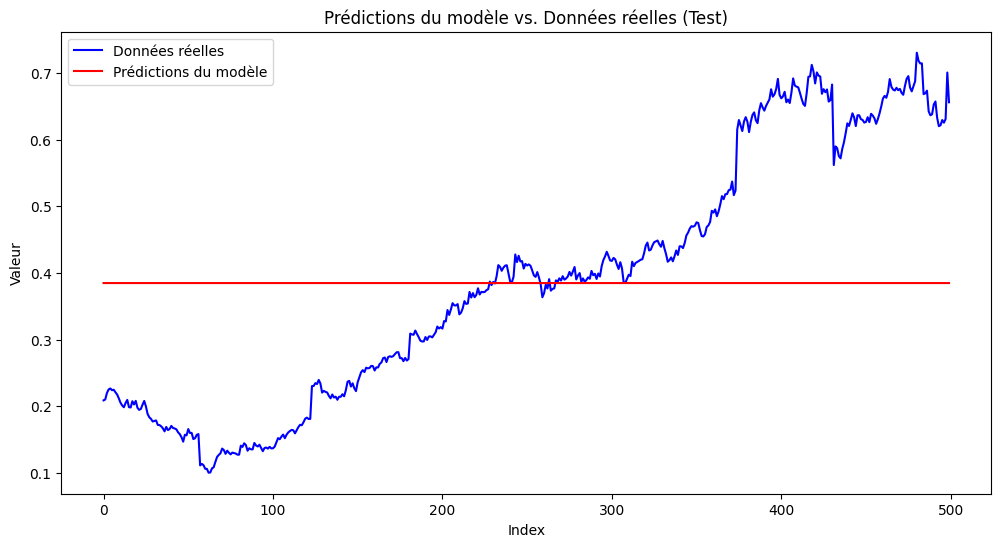

In [60]:
# Évaluation sur les données d'entraînement
model.eval()
with torch.no_grad():
    train_predictions = model(X_train).cpu().numpy()
    actual_train = y_train.cpu().numpy()

    mae = mean_absolute_error(actual_train, train_predictions)
    mse = mean_squared_error(actual_train, train_predictions)
    print(f'Train MAE: {mae:.4f}, Train MSE: {mse:.4f}')

    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(len(actual_train)), actual_train, color='blue', label='Données réelles')
    plt.plot(np.arange(len(train_predictions)), train_predictions, color='red', label='Prédictions du modèle')
    plt.title('Prédictions du modèle vs. Données réelles (Entraînement)')
    plt.xlabel('Index')
    plt.ylabel('Valeur')
    plt.legend()
    plt.show()

# Évaluation sur les données de test
length = 500
with torch.no_grad():
    test_predictions = model(X_test).cpu().numpy()[:length]
    actual_test = y_test.cpu().numpy()[:length]

    test_mae = mean_absolute_error(actual_test, test_predictions)
    test_mse = mean_squared_error(actual_test, test_predictions)
    print(f'Test MAE: {test_mae:.4f}, Test MSE: {test_mse:.4f}')

    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(len(actual_test)), actual_test, color='blue', label='Données réelles')
    plt.plot(np.arange(len(test_predictions)), test_predictions, color='red', label='Prédictions du modèle')
    plt.title('Prédictions du modèle vs. Données réelles (Test)')
    plt.xlabel('Index')
    plt.ylabel('Valeur')
    plt.legend()
    plt.show()
